Running simulation for N = 2, s = 0.0
Running simulation for N = 2, s = 1.0
Running simulation for N = 3, s = 0.0
Running simulation for N = 3, s = 1.0
Running simulation for N = 4, s = 0.0
Running simulation for N = 4, s = 1.0
Running simulation for N = 5, s = 0.0
Running simulation for N = 5, s = 1.0
Running simulation for N = 6, s = 0.0
Running simulation for N = 6, s = 1.0
Running simulation for N = 7, s = 0.0
Running simulation for N = 7, s = 1.0
Running simulation for N = 8, s = 0.0
Running simulation for N = 8, s = 1.0
Running simulation for N = 9, s = 0.0
Running simulation for N = 9, s = 1.0
Running simulation for N = 10, s = 0.0
Running simulation for N = 10, s = 1.0


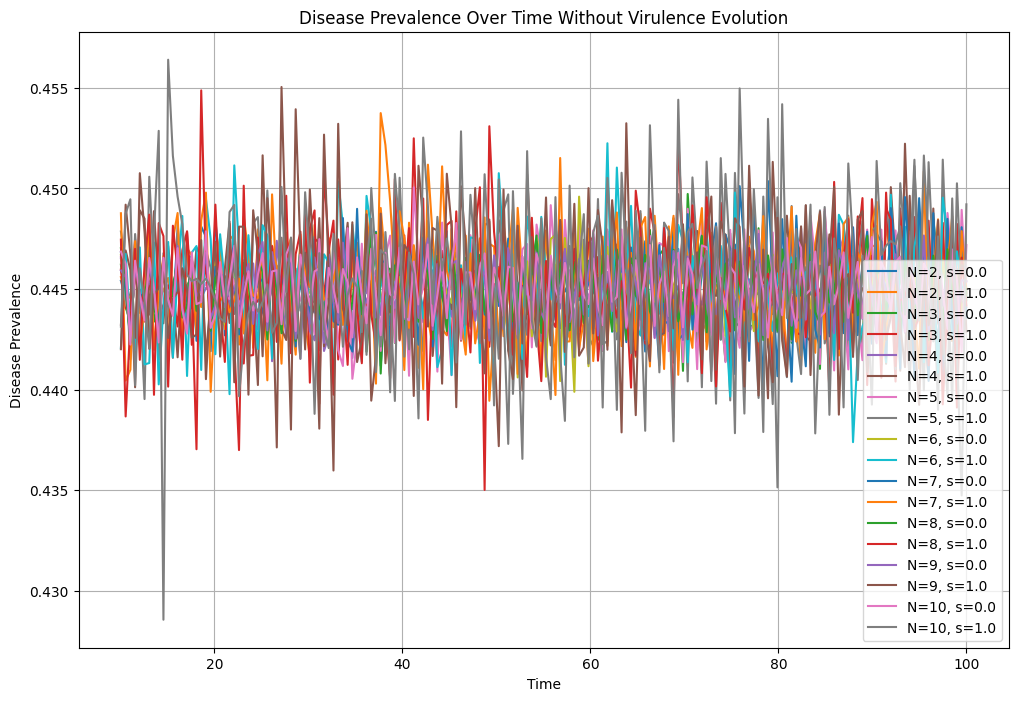

In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
numTraits = 50        # Maximum number of virulence traits (variants)
abs_ext_tol = 0       # Absolute extinction threshold
evolSteps = 100       # Number of evolutionary steps (adjusted for faster simulation)

# Fixed Parameters
d = 1.0
q = 1.0
gamma = 0.2
theta = 1.2
delta = 1.5
b = 12.0

# Trait space
alphaLow = 1.0
alphaHigh = 4.0
myAlpha = np.linspace(alphaLow, alphaHigh, numTraits)

def create_infection_matrix(s, N):
    Q = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                Q[i, j] = N * 0.5 * (1.0 + s)
            else:
                Q[i, j] = N * (1.0 / (2.0 * (N - 1))) * (1.0 - s)
    return Q

def allele_dynamics(t, y, params):
    N = params['N']
    numTraits = params['numTraits']
    Q = params['Q']
    myAlpha = params['myAlpha']
    s = params['s']
    b = params['b']
    gamma = params['gamma']
    theta = params['theta']
    delta = params['delta']
    d = params['d']
    q = params['q']
    
    # Unpack the state vector y
    idx = 0
    S = y[idx:idx+N]
    idx += N
    
    dydt = np.zeros_like(y)
    
    # Initialize infection and recovery terms
    infectionS = np.zeros(N)
    recoveryS = np.zeros(N)
    
    # Total population
    totalPopulation = np.sum(S)
    
    for trait in range(numTraits):
        idx_trait = idx + trait * (N * N + N)
        Iab_start = idx_trait
        Pb_start = Iab_start + N * N
        
        alpha_sqrt = 2 * 10 * np.sqrt(myAlpha[trait] / 10.0)
        
        # Pb vector for trait
        Pb = y[Pb_start:Pb_start+N]
        
        # Iab matrix for trait
        Iab = y[Iab_start:Iab_start+N*N].reshape(N, N)
        
        # Skip computation if both Iab and Pb are zero for this trait
        total_Iab_Pb = np.sum(Iab) + np.sum(Pb)
        if total_Iab_Pb < abs_ext_tol:
            continue  # Skip this trait as it has no active populations
        
        # Update totalPopulation with infected hosts
        totalPopulation += np.sum(Iab)
        
        # Compute derivatives for Iab and Pb
        dIab = np.zeros((N, N))
        for a in range(N):
            for b_idx in range(N):
                Iab_ab = Iab[a, b_idx]
                P_b = Pb[b_idx]
                
                dIab[a, b_idx] = Q[a, b_idx] * alpha_sqrt * P_b * S[a] - (d + gamma + myAlpha[trait]) * Iab_ab
                
                # Accumulate infection and recovery terms
                infectionS[a] += alpha_sqrt * Q[a, b_idx] * P_b * S[a]
                recoveryS[a] += gamma * Iab_ab
                
        # Flatten dIab and assign to dydt
        dydt[Iab_start:Iab_start+N*N] = dIab.flatten()
        
        # Compute derivatives for Pb
        dPb = np.zeros(N)
        for b_idx in range(N):
            sum_Iab = np.sum(Iab[:, b_idx])
            dPb[b_idx] = theta * sum_Iab - delta * Pb[b_idx]
            
        dydt[Pb_start:Pb_start+N] = dPb
    
    # Calculate dS/dt
    dS = b * S * (1.0 - q * totalPopulation) - d * S - infectionS + recoveryS
    dydt[0:N] = dS
    
    return dydt

def setup_simulation(N, s):
    params = {
        'd': d,
        'q': q,
        'gamma': gamma,
        'theta': theta,
        'delta': delta,
        'b': b,
        's': s,
        'myAlpha': myAlpha,
        'numTraits': numTraits,
        'N': N
    }
    
    # Create infection matrix Q
    params['Q'] = create_infection_matrix(s, N)
    
    # Initial conditions
    constantFactor = 1.0
    total_initial_susceptible = 0.9 * constantFactor
    S0_value = total_initial_susceptible / N
    S0 = np.full(N, S0_value)
    
    total_initial_infected = 0.1 * constantFactor
    I0_value = total_initial_infected / (N * N)
    I0 = np.full(N * N, I0_value)
    
    total_initial_parasites = 0.095 * constantFactor
    P0_value = total_initial_parasites / N
    P0 = np.full(N, P0_value)
    
    # State vector y0
    y0_size = N + numTraits * (N * N + N)
    y0 = np.zeros(y0_size)
    
    idx = 0
    y0[idx:idx+N] = S0
    idx += N
    
    # Initialize Iab and Pb for trait 0 only
    trait = 0
    idx_trait = idx + trait * (N * N + N)
    Iab_start = idx_trait
    Pb_start = Iab_start + N * N
    
    # Initialize Iab for trait 0
    y0[Iab_start:Iab_start+N*N] = I0
    
    # Initialize Pb for trait 0
    y0[Pb_start:Pb_start+N] = P0
    
    return y0, params

def run_simulation(N_values, s_values):
    # Time span for integration
    t0 = 0.0
    t1 = 100.0  # Adjusted for faster simulation
    t_eval = np.linspace(t0, t1, 200)  # Time points where the solution is evaluated
    
    # Store results for plotting
    results = {}
    
    for N in N_values:
        for s in s_values:
            print(f"Running simulation for N = {N}, s = {s}")
            y0, params = setup_simulation(N, s)
            
            # Integrate the ODE
            sol = solve_ivp(fun=lambda t, y: allele_dynamics(t, y, params),
                            t_span=(t0, t1),
                            y0=y0,
                            t_eval=t_eval,
                            method='RK45')
            
            # Calculate disease prevalence over time
            disease_prevalence = []
            for y in sol.y.T:
                idx = 0
                S = y[idx:idx+N]
                idx += N
                
                total_infected = 0.0
                total_population = np.sum(S)
                
                for trait in range(numTraits):
                    idx_trait = idx + trait * (N * N + N)
                    Iab_start = idx_trait
                    Pb_start = Iab_start + N * N
                    
                    Iab = y[Iab_start:Iab_start+N*N]
                    sum_Iab = np.sum(Iab)
                    total_infected += sum_Iab
                    
                total_population += total_infected
                disease_prevalence.append(total_infected / total_population)
            
            # Store the results
            key = f"N={N}, s={s}"
            results[key] = (sol.t, disease_prevalence)
    
    return results

def plot_results(results):
    plt.figure(figsize=(12, 8))
    
    for key, (t, disease_prevalence) in results.items():
        plt.plot(t[20:], disease_prevalence[20:], label=key)
    
    plt.xlabel('Time')
    plt.ylabel('Disease Prevalence')
    plt.title('Disease Prevalence Over Time Without Virulence Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()

N_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
s_values = [0.0, 1.0]
    
results = run_simulation(N_values, s_values)
plot_results(results)

Running simulation for N = 2, s = 0.0
Running simulation for N = 2, s = 1.0
Running simulation for N = 5, s = 0.0
Running simulation for N = 5, s = 1.0


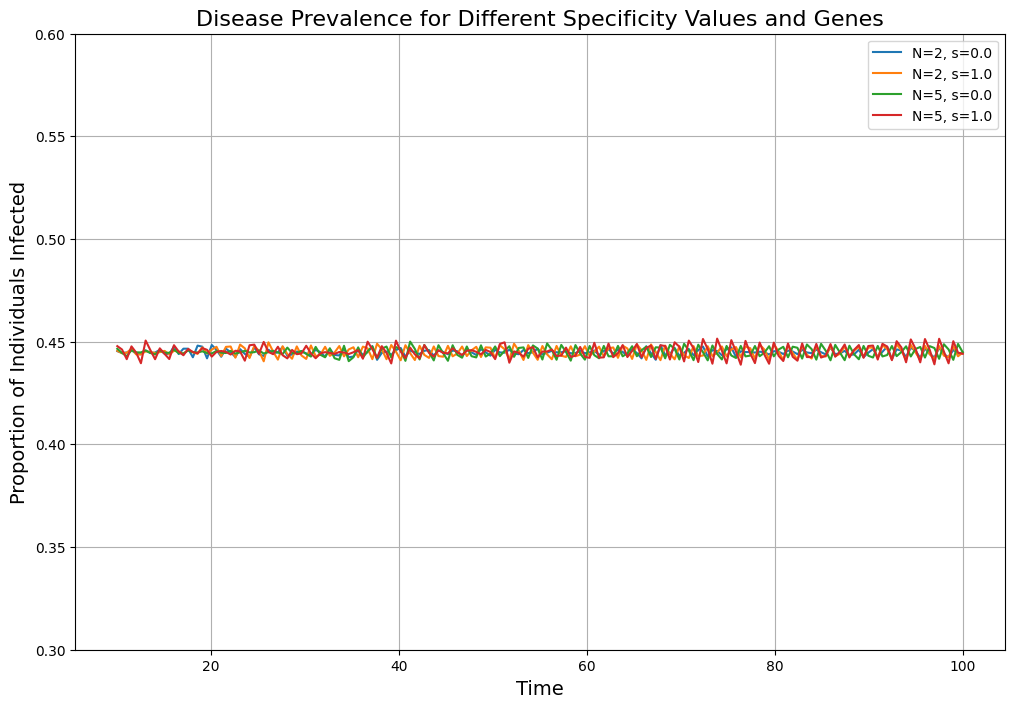

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parameters
numTraits = 50        # Maximum number of virulence traits (variants)
abs_ext_tol = 0       # Absolute extinction threshold
evolSteps = 100       # Number of evolutionary steps (adjusted for faster simulation)

# Fixed Parameters
d = 1.0
q = 1.0
gamma = 0.2
theta = 1.2
delta = 1.5
b = 12.0

# Trait space
alphaLow = 1.0
alphaHigh = 4.0
myAlpha = np.linspace(alphaLow, alphaHigh, numTraits)

def create_infection_matrix(s, N):
    Q = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                Q[i, j] = N * 0.5 * (1.0 + s)
            else:
                Q[i, j] = N * (1.0 / (2.0 * (N - 1))) * (1.0 - s)
    return Q

def allele_dynamics(t, y, params):
    N = params['N']
    numTraits = params['numTraits']
    Q = params['Q']
    myAlpha = params['myAlpha']
    s = params['s']
    b = params['b']
    gamma = params['gamma']
    theta = params['theta']
    delta = params['delta']
    d = params['d']
    q = params['q']
    
    # Unpack the state vector y
    idx = 0
    S = y[idx:idx+N]
    idx += N
    
    dydt = np.zeros_like(y)
    
    # Initialize infection and recovery terms
    infectionS = np.zeros(N)
    recoveryS = np.zeros(N)
    
    # Total population
    totalPopulation = np.sum(S)
    
    for trait in range(numTraits):
        idx_trait = idx + trait * (N * N + N)
        Iab_start = idx_trait
        Pb_start = Iab_start + N * N
        
        alpha_sqrt = 2 * 10 * np.sqrt(myAlpha[trait] / 10.0)
        
        # Pb vector for trait
        Pb = y[Pb_start:Pb_start+N]
        
        # Iab matrix for trait
        Iab = y[Iab_start:Iab_start+N*N].reshape(N, N)
        
        # Skip computation if both Iab and Pb are zero for this trait
        total_Iab_Pb = np.sum(Iab) + np.sum(Pb)
        if total_Iab_Pb < abs_ext_tol:
            continue  # Skip this trait as it has no active populations
        
        # Update totalPopulation with infected hosts
        totalPopulation += np.sum(Iab)
        
        # Compute derivatives for Iab and Pb
        dIab = np.zeros((N, N))
        for a in range(N):
            for b_idx in range(N):
                Iab_ab = Iab[a, b_idx]
                P_b = Pb[b_idx]
                
                dIab[a, b_idx] = Q[a, b_idx] * alpha_sqrt * P_b * S[a] - (d + gamma + myAlpha[trait]) * Iab_ab
                
                # Accumulate infection and recovery terms
                infectionS[a] += alpha_sqrt * Q[a, b_idx] * P_b * S[a]
                recoveryS[a] += gamma * Iab_ab
                
        # Flatten dIab and assign to dydt
        dydt[Iab_start:Iab_start+N*N] = dIab.flatten()
        
        # Compute derivatives for Pb
        dPb = np.zeros(N)
        for b_idx in range(N):
            sum_Iab = np.sum(Iab[:, b_idx])
            dPb[b_idx] = theta * sum_Iab - delta * Pb[b_idx]
            
        dydt[Pb_start:Pb_start+N] = dPb
    
    # Calculate dS/dt
    dS = b * S * (1.0 - q * totalPopulation) - d * S - infectionS + recoveryS
    dydt[0:N] = dS
    
    return dydt

def setup_simulation(N, s):
    params = {
        'd': d,
        'q': q,
        'gamma': gamma,
        'theta': theta,
        'delta': delta,
        'b': b,
        's': s,
        'myAlpha': myAlpha,
        'numTraits': numTraits,
        'N': N
    }
    
    # Create infection matrix Q
    params['Q'] = create_infection_matrix(s, N)
    
    # Initial conditions
    constantFactor = 1.0
    total_initial_susceptible = 0.9 * constantFactor
    S0_value = total_initial_susceptible / N
    S0 = np.full(N, S0_value)
    
    total_initial_infected = 0.1 * constantFactor
    I0_value = total_initial_infected / (N * N)
    I0 = np.full(N * N, I0_value)
    
    total_initial_parasites = 0.095 * constantFactor
    P0_value = total_initial_parasites / N
    P0 = np.full(N, P0_value)
    
    # State vector y0
    y0_size = N + numTraits * (N * N + N)
    y0 = np.zeros(y0_size)
    
    idx = 0
    y0[idx:idx+N] = S0
    idx += N
    
    # Initialize Iab and Pb for trait 0 only
    trait = 0
    idx_trait = idx + trait * (N * N + N)
    Iab_start = idx_trait
    Pb_start = Iab_start + N * N
    
    # Initialize Iab for trait 0
    y0[Iab_start:Iab_start+N*N] = I0
    
    # Initialize Pb for trait 0
    y0[Pb_start:Pb_start+N] = P0
    
    return y0, params

def run_simulation(N_values, s_values):
    # Time span for integration
    t0 = 0.0
    t1 = 100.0  # Adjusted for faster simulation
    t_eval = np.linspace(t0, t1, 200)  # Time points where the solution is evaluated
    
    # Store results for plotting
    results = {}
    
    for N in N_values:
        for s in s_values:
            print(f"Running simulation for N = {N}, s = {s}")
            y0, params = setup_simulation(N, s)
            
            # Integrate the ODE
            sol = solve_ivp(fun=lambda t, y: allele_dynamics(t, y, params),
                            t_span=(t0, t1),
                            y0=y0,
                            t_eval=t_eval,
                            method='RK45')
            
            # Calculate disease prevalence over time
            disease_prevalence = []
            for y in sol.y.T:
                idx = 0
                S = y[idx:idx+N]
                idx += N
                
                total_infected = 0.0
                total_population = np.sum(S)
                
                for trait in range(numTraits):
                    idx_trait = idx + trait * (N * N + N)
                    Iab_start = idx_trait
                    Pb_start = Iab_start + N * N
                    
                    Iab = y[Iab_start:Iab_start+N*N]
                    sum_Iab = np.sum(Iab)
                    total_infected += sum_Iab
                    
                total_population += total_infected
                disease_prevalence.append(total_infected / total_population)
            
            # Store the results
            key = f"N={N}, s={s}"
            results[key] = (sol.t, disease_prevalence)
    
    return results

def plot_results(results):
    plt.figure(figsize=(12, 8))
    
    for key, (t, disease_prevalence) in results.items():
        plt.plot(t[20:], disease_prevalence[20:], label=key)
    
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Proportion of Individuals Infected', fontsize=14)
    plt.title('Disease Prevalence for Different Specificity Values and Genes', fontsize=16)
    plt.legend()
    plt.grid(True)
    plt.ylim(0.3, 0.6)  # Set y-axis range from 0 to 1
    plt.yticks(np.arange(0.3, 0.61, 0.05))  # Set y-axis ticks at intervals of 0.1
    plt.savefig('diseasePrev.png', dpi=500)
    plt.show()

N_values = [2, 5]
s_values = [0.0, 1.0]
    
results = run_simulation(N_values, s_values)
plot_results(results)